# 5.1 Criação de Modelos de Machine Learning - Tunning

## Carregar dados tratados

In [51]:
# ! pip install seaborn
# ! pip install plotly
# ! pip install statsmodels
# ! pip install sklearn
# ! pip install xgboost

In [82]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, AdaBoostClassifier

from sklearn.model_selection import RandomizedSearchCV

import joblib

In [53]:
def carregar_joblib(file_name: str = "../out/result_analise_desc_scaled.joblib"):
    df = joblib.load(file_name)
    return df

In [89]:
def split_dados(df):
    X = df.drop(["decisao"], axis=1)
    y = df["decisao"]

    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.15, random_state=2)

    print(f"{len(X_treino)=} {len(X_teste)=} {len(y_treino)=} {len(y_teste)=}")

    return X_treino, X_teste, y_treino, y_teste

In [126]:
def avaliar(y_teste, y_prev, nome_modelo):
    print(nome_modelo)
    print("Reporte teste")
    report = classification_report(y_teste, y_prev)
    # print(report)
    cf_matrix = pd.DataFrame(confusion_matrix(y_teste, y_prev), index=["Vender", "Comprar"], columns=["Vender", "Comprar"])
    # sns.heatmap(cf_matrix, annot=True, cmap="Blues", fmt=',')
    # plt.show()
    print("Acuracia: ", accuracy_score(y_teste, y_prev))
    print("#" * 50)
    return accuracy_score(y_teste, y_prev)


# ML modelos

## Modelos a serem testados

- Random Forest
- Gradient Boost
- AdaBoost

In [99]:
def definir_modelos_ml() -> dict:
    return {
        "AdaBoost": {'modelo_base': AdaBoostClassifier(random_state=42), 'modelo_tunado': None},
        "RandomForest": {'modelo_base': RandomForestClassifier(random_state=42), 'modelo_tunado': None},
        "GradientBoost": {'modelo_base': GradientBoostingClassifier(random_state=42), 'modelo_tunado': None},
    }

In [107]:
def rodar_imprimir_modelos_ml(modelos, X_treino, X_teste, y_treino, y_teste):
    for nome, modelo in modelos.items():
        modelo = modelo.get('modelo_base')
        modelo.fit(X_treino, y_treino)
        previsoes = modelo.predict(X_teste)
        modelos[nome]['modelo_base'] = modelo
    
    return modelos

# Execucao

In [108]:
def main(scaled: bool = False):
    if scaled:
        df = carregar_joblib("../out/result_analise_desc_scaled.joblib")
        print("scaled df")
    else:
        df = carregar_joblib()
        print("NOT scaled df")

    print(df.shape)

    # split database train and test
    X_treino, X_teste, y_treino, y_teste = split_dados(df)

    modelos = definir_modelos_ml()

    modelos = rodar_imprimir_modelos_ml(modelos, X_treino, X_teste, y_treino, y_teste)

    return df, modelos

df, modelos = main(scaled=True)

scaled df
(1852, 6)
len(X_treino)=1574 len(X_teste)=278 len(y_treino)=1574 len(y_teste)=278


/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(


## Tunning dos 3 melhores modelos

In [86]:
def fit_tunning_rand_search_ada(X, y):
    print("Tunning randomized search AdaBoost")

    # Create the random grid
    param = {'n_estimators': [50, 80, 90, 100],
             'learning_rate': [0.2, 1.0, 0.1],
             'algorithm': ["SAMME", "SAMME.R"]}

    print(param)

    rf_random = RandomizedSearchCV(estimator=AdaBoostClassifier(),
                                   param_distributions=param,
                                   cv=3,
                                   verbose=1,
                                   scoring="accuracy",
                                   random_state=42,
                                   n_jobs=-1)

    # best params {'n_estimators': 80, 'learning_rate': 0.1, 'algorithm': 'SAMME.R'}
    # precision 1 - 0.59 0.63 0.61 - score 0.5704

    # Fit the random search model
    return rf_random.fit(X, y)

In [75]:
def fit_tunning_rand_search_random_forest(X, y):

    print("Tunning Random Forest")

    # Create the random grid
    params = {'n_estimators': [1200, 1400, 1600],
                   'max_depth': [10, None],
                   'min_samples_split': [2, 4],
                   'min_samples_leaf': [1, 2, 5],
                   'bootstrap': [True, False]}

    print(params)

    rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(),
                                   param_distributions=params,
                                   cv=3,
                                   verbose=1,
                                   scoring='recall',
                                   random_state=42,
                                   n_jobs=-1)

    # best params {'n_estimators': 1600, 'min_samples_split': 2, 'min_samples_leaf': 5, 'max_depth': 10, 'bootstrap': False}
    # precision 1 - 0.51 0.59 0.55

    # Fit the random search model
    return rf_random.fit(X, y)

In [74]:
def fit_tunning_rand_search_gradient_boost(X, y):

    params = {'n_estimators': [800, 900, 1000],
                   'learning_rate': [0.01, 0.015, 0.009],
                   'max_features': ['auto', 'sqrt'],
                   'min_samples_split': [2, 5, 10],
                   # 'min_samples_leaf': [2, 5, 10],
                   'criterion': ["friedman_mse", "squared_error"]}

    print(params)

    rf_random = RandomizedSearchCV(estimator=GradientBoostingClassifier(),
                                   param_distributions=params,
                                   cv=3,
                                   verbose=1,
                                   scoring="recall",
                                   random_state=42,
                                   n_jobs=-1)

    # best params {'n_estimators': 1411, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 110, 'learning_rate': 0.025, 'criterion': 'squared_error'}
    # {'n_estimators': 1000, 'min_samples_split': 10, 'max_features': 'auto', 'learning_rate': 0.01, 'criterion': 'squared_error'}
    # precision 1 - 0.57 0.68 0.62 - score 0.5609

    # Fit the random search model
    return rf_random.fit(X, y)


In [114]:

def run_ada_boost_tunning(X_treino, y_treino):

    resultado_grid = fit_tunning_rand_search_ada(X_treino.values, y_treino.values)

    print("Ajuste Adaboost feito")

    print("Best params", resultado_grid.best_params_)
    print("Best score", resultado_grid.best_score_)

    modelo_tunado = resultado_grid.best_estimator_

    return modelo_tunado

In [115]:

def run_random_forest_tunning(X_treino, y_treino):

    resultado_grid = fit_tunning_rand_search_random_forest(X_treino, y_treino)

    print("Ajuste random forest feito")

    print("best params", resultado_grid.best_params_)
    print("best score", resultado_grid.best_score_)
    modelo_tunado = resultado_grid.best_estimator_

    return modelo_tunado

In [116]:

def run_gradient_boost_tunning(X_treino, y_treino):

    resultado_grid = fit_tunning_rand_search_gradient_boost(X_treino, y_treino)

    print("Ajuste Gradient feito")

    print("Best params", resultado_grid.best_params_)
    print("Best score", resultado_grid.best_score_)

    modelo_tunado = resultado_grid.best_estimator_

    return modelo_tunado

In [148]:
def compare_tunning(modelos: dict, X_teste, y_teste):
    acuracias = {}
    for nome, modelos_dict in modelos.items():
        prev = modelos_dict['modelo_base'].predict(X_teste)
        # avaliar(y_teste, prev, nome + '_base')
        prev = modelos_dict['modelo_tunado'].predict(X_teste)
        acuracias[nome] = avaliar(y_teste, prev, nome + '_tunado')
    
    sns.set_theme(style="whitegrid")
    ax = sns.barplot(x=list(acuracias.keys()), y=list(acuracias.values()))
    ax.set(xlabel="Modelos", ylabel="Acuracia", title="Acuracia por Modelo")
    

In [120]:
def main_tunning(df, modelos, X_treino, y_treino):
    '''
        Executa os tunnings com randomized search cv e armazena o modelo tunado
    '''

    modelos['AdaBoost']['modelo_tunado'] = run_ada_boost_tunning(X_treino, y_treino)
    modelos['RandomForest']['modelo_tunado'] = run_random_forest_tunning(X_treino, y_treino)
    modelos['GradientBoost']['modelo_tunado'] = run_gradient_boost_tunning(X_treino, y_treino)

    return modelos


len(X_treino)=1574 len(X_teste)=278 len(y_treino)=1574 len(y_teste)=278
AdaBoost_tunado
Reporte teste
Acuracia:  0.5251798561151079
##################################################


/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
/Users/shopee/opt/anaconda3/envs/TCC_PUC/lib/python3.8/site-packages/sklearn/base.py:434: UserWarning: X has feature names, but AdaBoostClassifier was fitted without feature names
  warnings.warn(


RandomForest_tunado
Reporte teste
Acuracia:  0.5
##################################################
GradientBoost_tunado
Reporte teste
Acuracia:  0.5431654676258992
##################################################


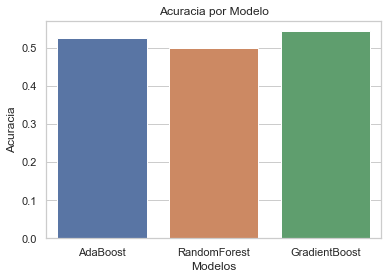

In [149]:
# split database train and test
X_treino, X_teste, y_treino, y_teste = split_dados(df)

# modelos = main_tunning(df, modelos, X_treino, y_treino)

compare_tunning(modelos, X_teste, y_teste)

# Escolhido o GradientBoost como melhor modelo

Best score de 54%